In [822]:
import pandas as pd
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
import seaborn as sns
import matplotlib.pyplot as plt
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import preprocessing
import numpy as np
from wordcloud import WordCloud, STOPWORDS

In [660]:
#create a list of unnecessary words
stoplist = set(stopwords.words('english') + list(string.punctuation))
stoplist.add('...')

lemma = WordNetLemmatizer()
tknzer = TweetTokenizer()

In [661]:
#tokenizes words 
def preprocess(text):
    filtered = [lemma.lemmatize(word) for word in tknzer.tokenize(text)]

    return filtered

#tokenizes words and removes stoplist wors
def preprocess_stoplist(text):
    filtered =[word for word in preprocess(text) if word not in stoplist]
    return filtered

#creates wordcloud with adjustable background colors
def create_word_cloud(text, color, title):
    wc = WordCloud(max_words = 100, stopwords = stoplist,background_color = color,width = 2000, height = 1500).generate(text)

    plt.figure(figsize = (10,10))
    plt.imshow(wc)
    plt.title(title)
    plt.axis("off")    
    plt.show()
    
#creates frequency plot for word count    
def freq_plot(freq):
    plt.rcParams.update({'font.size': 22})
    plt.figure(figsize =(12,8))
    
    freq.plot(30)

In [844]:
#reads in depressed data
depressed_df = pd.read_csv('depressed_comments.csv', delimiter = ',')

#sets label and column
depressed_df.columns = ['Comment']
depressed_df['Label'] = 1

#reads in non-depressed data and resizes to match depressed
non_depress_df = pd.read_csv('non_depressed_comments.csv', delimiter = ',')[:len(depressed_df)]

#shuffles the data
non_depress_df = shuffle(non_depress_df).reset_index(drop = True)

#sets label and column
non_depress_df.columns = ['Comment']
non_depress_df['Label'] = 0

#combines non-depressed and depressed data and shuffles
df = pd.concat([depressed_df,non_depress_df])
df = shuffle(df).reset_index(drop = True)




In [828]:
#in order to use nltk.FreqDist, combines all depressed words into one string
depress_txt = depressed_df.Comment.str.cat(sep=',')
depressed_freq = FreqDist(preprocess_stoplist(depress_txt))
freq_df = pd.DataFrame(depressed_freq.most_common(30),columns =['Word','Frequency'])
freq_df.head()

,Word,Frequency
0,I,3408
1,’,673
2,I'm,499
3,wa,360
4,like,360


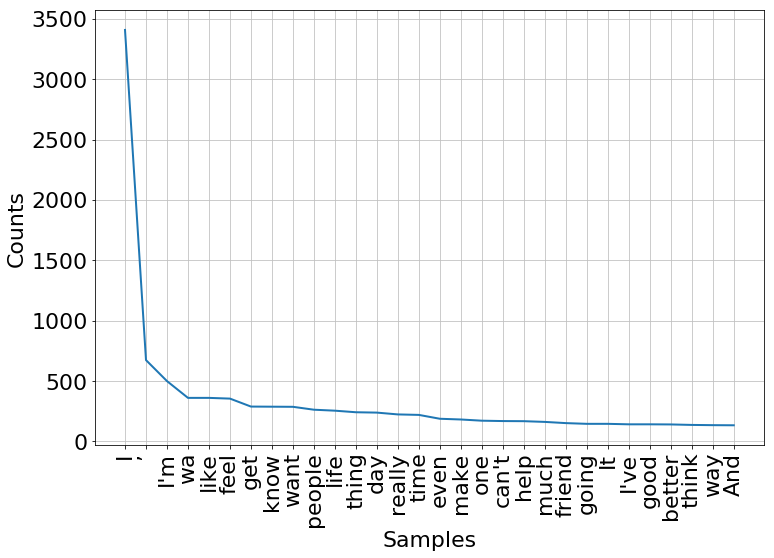

In [664]:
freq_plot(depressed_freq)

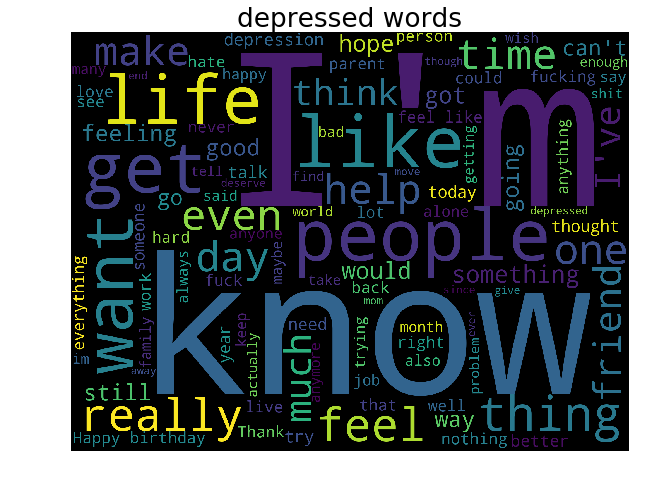

In [665]:
create_word_cloud(depress_txt,color = 'black', title = 'depressed words')

In [666]:
#in order to use nltk.FreqDist, combines all non-depressed words into one string
non_depress_txt = non_depress_df.Comment.str.cat(sep=',')
non_depress_freq = FreqDist(preprocess_stoplist(non_depress_txt))
freq_df = pd.DataFrame(non_depress_freq.most_common(30),columns =['Word','Frequency'])
freq_df.head()

,Word,Frequency
0,I,2060
1,like,304
2,upvote,298
3,I'm,246
4,’,233


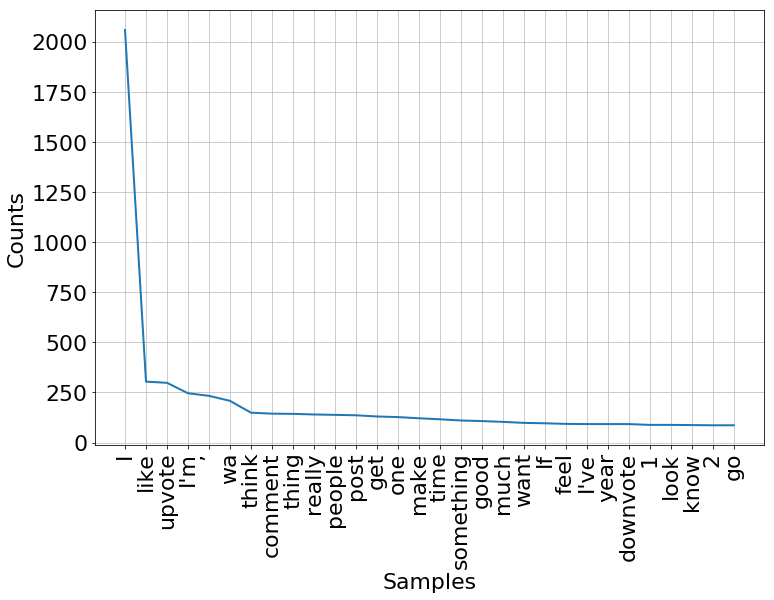

In [667]:
freq_plot(non_depress_freq)

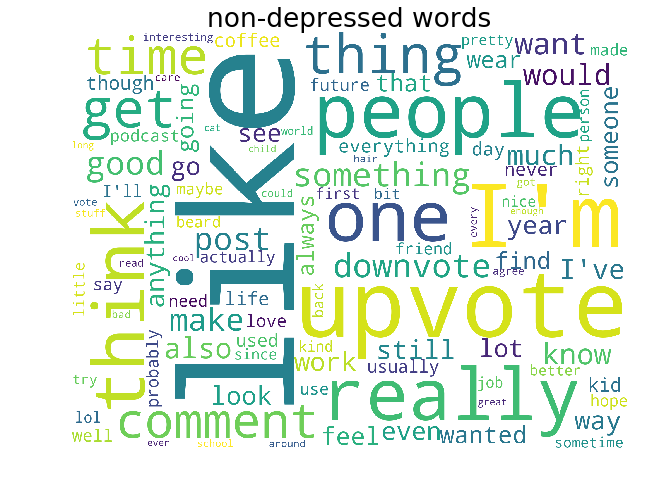

In [668]:
create_word_cloud(non_depress_txt,color = 'white', title = 'non-depressed words')

In [862]:
#sets the X and y input for model building 
X = df['Comment']

y = df['Label']

#creates bag of words feature
count_vect = CountVectorizer(tokenizer = preprocess, stop_words = stoplist)
X_count_vect = count_vect.fit_transform(X)
X_train_count, X_test_count, y_train, y_test = train_test_split(X_count_vect,y,test_size =.33)





In [863]:
#creates Term Frequency - Inverse Document Frequency feature at word-level
tfidf = TfidfVectorizer(tokenizer = preprocess, stop_words = stoplist, smooth_idf=True)
X_tfidf = tfidf.fit_transform(X)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_count_vect,y,test_size =.33)


In [864]:
tfidf_ngram = TfidfVectorizer(tokenizer = preprocess, stop_words = stoplist, smooth_idf=True,ngram_range = (1,3) )
X_ngram = tfidf_ngram.fit_transform(X)
X_train_tfidf_ngram, X_test_tfidf_ngram, y_train, y_test = train_test_split(X_ngram,y,test_size =.33)


In [865]:
#Linear Classification (Logistical regression)
logistic = LogisticRegression()
clf = logistic.fit(X_train_tfidf_ngram,y_train)
preds = clf.predict(X_test_tfidf_ngram)

In [866]:
print(classification_report(y_test,preds))

             precision    recall  f1-score   support

          0       0.82      0.87      0.85       347
          1       0.87      0.83      0.85       366

avg / total       0.85      0.85      0.85       713



In [868]:
#example taken from depressed.csv
singular_neg = ["I have no friends. I'm in college in the 'best years \
of my life' and all I can ever do is think about how much I want to kill myself, \
and how bad I'm doing all the time. I'm too poor to afford a\
therapist/medication, I have a family that is incredibly not supportive of mental health."]

singular_vector_neg = tfidf_ngram.transform(singular_neg)


In [869]:
clf.predict(singular_vector_neg)

array([1])

In [870]:
singular_pos = ["veing positive is great"]
singular_vector_pos = tfidf_ngram.transform(singular_pos)


In [871]:
clf.predict(singular_vector_pos)

array([0])